In [ ]:
#improved:::

# ✅ Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
pip install torch torchvision torch audio torch-geometric pandas numpy scikit-learn


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 931.5/931.5 kB 17.0 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
!pip install torch torchvision torchaudio
!pip install torch-geometric
!pip install scikit-learn pandas numpy


  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.5.147-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.3.1.170-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
from torch_geometric.data import Data
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.neighbors import kneighbors_graph
from imblearn.over_sampling import SMOTE
import time

# Load paths
csv_path = '/content/drive/MyDrive/unprocessed_protein_drug_ADR_dataset_4000.csv'
npy_path = '/content/drive/MyDrive/protein_embeddings_3000_4000_merged.npy'

# Load and prepare data
df = pd.read_csv(csv_path).tail(1000).reset_index(drop=True)
embeddings = np.load(npy_path)[:1000]
df['ADR_Predicted'] = LabelEncoder().fit_transform(df['ADR_Predicted'])

# Extract and scale features
drug_features = df.drop(columns=['Protein_ID', 'Drug_ID', 'ADR_Predicted']).values
drug_features = StandardScaler().fit_transform(drug_features)
X = np.concatenate([drug_features, embeddings], axis=1)
y = df['ADR_Predicted'].values

# Apply SMOTE
X_bal, y_bal = SMOTE().fit_resample(X, y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_bal, y_bal, test_size=0.2, random_state=42)


In [ ]:
# Build k-NN edge index (k=5 for memory safety)
adj = kneighbors_graph(X_train, n_neighbors=5, include_self=False)
edge_index = torch.tensor(adj.nonzero(), dtype=torch.long)[[1, 0]]  # transpose to [2, num_edges]

# PyG Data
x = torch.tensor(X_train, dtype=torch.float)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
data = Data(x=x, edge_index=edge_index, y=y_train_tensor)

# GraphSAGE GNN
class GraphSAGE(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, output_dim=2):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(input_dim, hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, 64)
        self.lin = nn.Linear(64, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.3, training=self.training)
        x = self.conv2(x, edge_index)
        return self.lin(x)

# Focal Loss
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        return (self.alpha * (1 - pt) ** self.gamma * ce_loss).mean()


<ipython-input-6-e49d6fd0f1cf>:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  edge_index = torch.tensor(adj.nonzero(), dtype=torch.long)[[1, 0]]  # transpose to [2, num_edges]


In [ ]:
# Device and model setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GraphSAGE(input_dim=X.shape[1], output_dim=2).to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
loss_fn = FocalLoss()

# Training
start_train = time.time()
model.train()
for epoch in range(100):
    optimizer.zero_grad()
    out = model(data)
    loss = loss_fn(out, data.y)
    loss.backward()
    optimizer.step()
end_train = time.time()

# Test-time k-NN graph
test_tensor = torch.tensor(X_test, dtype=torch.float).to(device)
test_adj = kneighbors_graph(X_test, n_neighbors=5, include_self=False)
test_edge_index = torch.tensor(test_adj.nonzero(), dtype=torch.long)[[1, 0]].to(device)
test_data = Data(x=test_tensor, edge_index=test_edge_index).to(device)

# Evaluation
model.eval()
with torch.no_grad():
    start_test = time.time()
    logits = model(test_data)
    probs = F.softmax(logits, dim=1)[:, 1].cpu().numpy()
    preds = (probs > 0.4).astype(int)
    end_test = time.time()


In [ ]:
accuracy = accuracy_score(y_test, preds)
precision = precision_score(y_test, preds)
recall = recall_score(y_test, preds)
f1 = f1_score(y_test, preds)
roc_auc = roc_auc_score(y_test, probs)

print("=== Final Metrics ===")
print(f"Accuracy   : {accuracy:.4f}")
print(f"Precision  : {precision:.4f}")
print(f"Recall     : {recall:.4f}")
print(f"F1-Score   : {f1:.4f}")
print(f"ROC-AUC    : {roc_auc:.4f}")
print(f"Train Time : {round(end_train - start_train, 4)} sec")
print(f"Test Time  : {round(end_test - start_test, 4)} sec\n")

print("=== Classification Report ===")
print(classification_report(y_test, preds))


=== Final Metrics ===
Accuracy   : 0.9454
Precision  : 0.9149
Recall     : 0.9829
F1-Score   : 0.9477
ROC-AUC    : 0.9880
Train Time : 7.7206 sec
Test Time  : 0.0124 sec

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.98      0.91      0.94       173
           1       0.91      0.98      0.95       175

    accuracy                           0.95       348
   macro avg       0.95      0.95      0.95       348
weighted avg       0.95      0.95      0.95       348



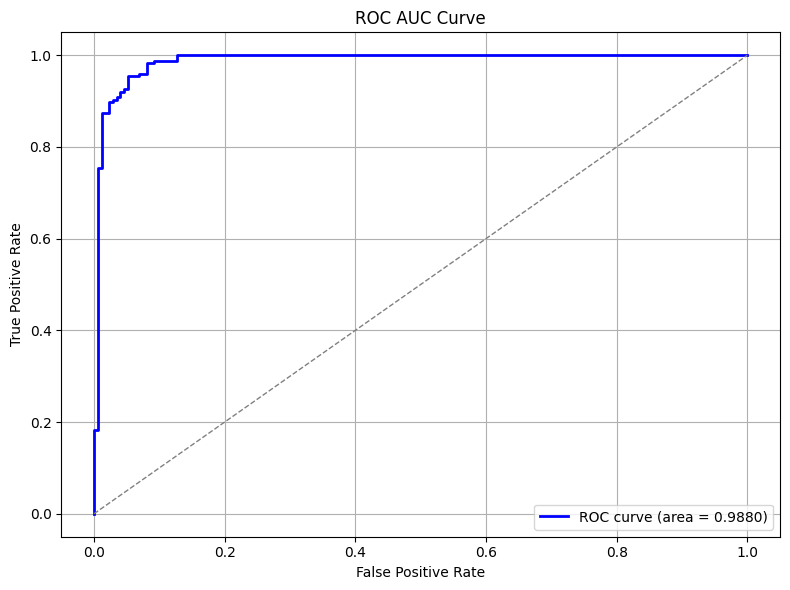

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Calculate ROC
fpr, tpr, _ = roc_curve(y_test, probs)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.tight_layout()
plt.show()


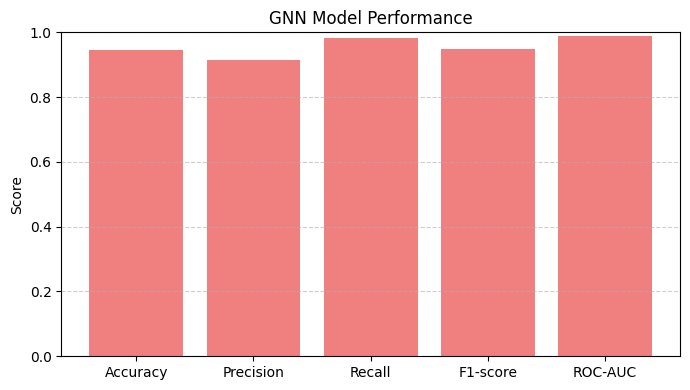

In [ ]:
gnn_metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC-AUC']
gnn_values = [0.9454, 0.9149, 0.9829, 0.9477, 0.9880]

plt.figure(figsize=(7, 4))
plt.bar(gnn_metrics, gnn_values, color='lightcoral')
plt.ylim(0, 1)
plt.title('GNN Model Performance')
plt.ylabel('Score')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

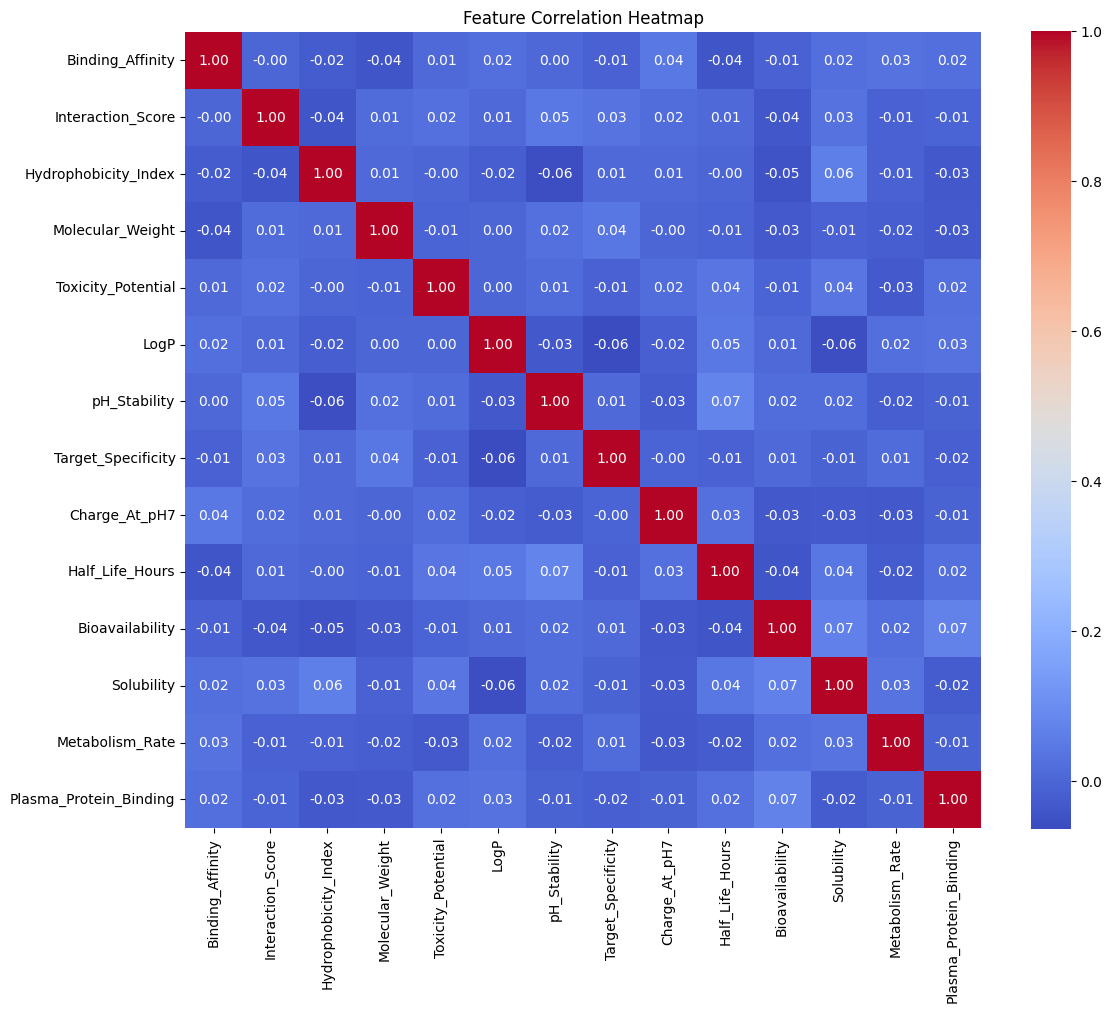

In [ ]:
import seaborn as sns

# Reload or use original dataframe
feature_df = df.drop(columns=['Protein_ID', 'Drug_ID', 'ADR_Predicted'])

# Combine with embeddings if desired
# embeddings_df = pd.DataFrame(embeddings, columns=[f'embed_{i}' for i in range(embeddings.shape[1])])
# combined_df = pd.concat([feature_df, embeddings_df], axis=1)

# Compute and plot correlation
plt.figure(figsize=(12, 10))
sns.heatmap(feature_df.corr(), annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()


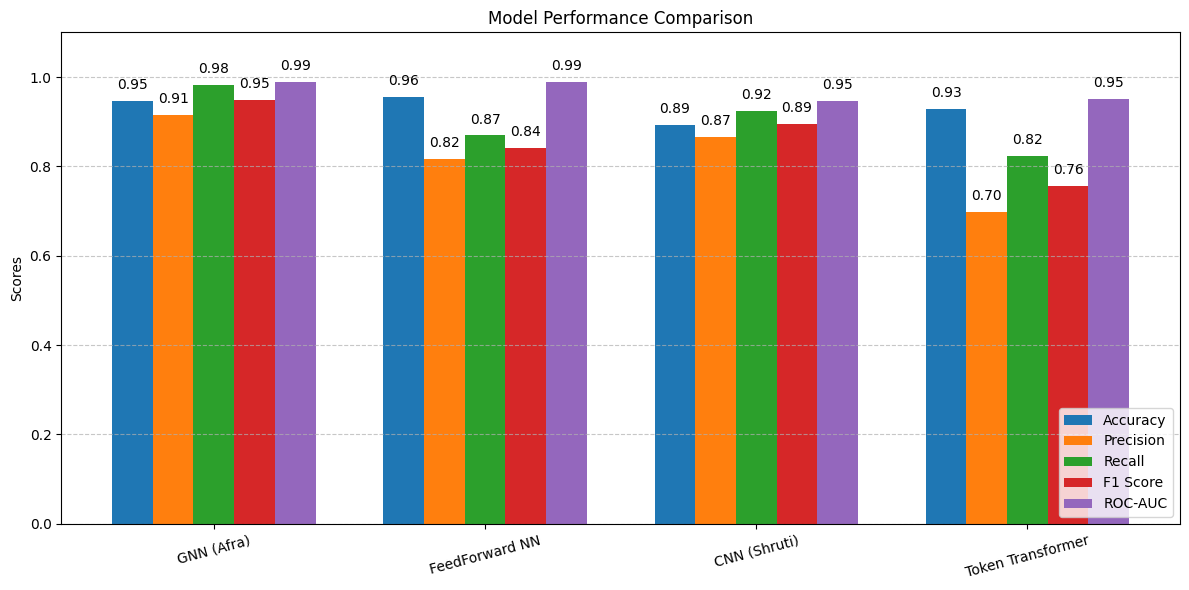

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Model names
models = ['GNN (Afra)', 'FeedForward NN', 'CNN (Shruti)', 'Token Transformer']

# Metrics for each model (in order)
accuracy =    [0.9454, 0.9563, 0.8924, 0.9287]
precision =   [0.9149, 0.8158, 0.8667, 0.6984]
recall =      [0.9829, 0.8692, 0.9231, 0.8224]
f1_score =    [0.9477, 0.8416, 0.8940, 0.7554]
roc_auc =     [0.9880, 0.9894, 0.9458, 0.9513]

# Set up figure
x = np.arange(len(models))
width = 0.15

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - 2*width, accuracy, width, label='Accuracy')
rects2 = ax.bar(x - width, precision, width, label='Precision')
rects3 = ax.bar(x, recall, width, label='Recall')
rects4 = ax.bar(x + width, f1_score, width, label='F1 Score')
rects5 = ax.bar(x + 2*width, roc_auc, width, label='ROC-AUC')

# Labels and formatting
ax.set_ylabel('Scores')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.set_ylim(0, 1.1)
ax.legend(loc='lower right')
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add values on top of bars
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height + 0.02),
                    ha='center', va='bottom')

for rect_group in [rects1, rects2, rects3, rects4, rects5]:
    add_labels(rect_group)

plt.tight_layout()
plt.show()